In [1]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from rl_introduction.tools import Agent, plot_values_lake, policy_improvement, discount_cumsum, run_experiment_episode_train
env = gym.make('FrozenLake-v0')

In [55]:
class MyRandomAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
        self.policy = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def act(self, state):
        action = np.random.choice(np.arange(self.env.action_space.n),p=self.policy[state])
        return action

# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}



[
$\frac{\sum_{i=1}^n \mathbb{1}[S_i = s] G_i}{\sum_{i=1}^n \mathbb{1}[S_i = s]} $
is convergent if $G_{s_i}$ is Independent and identically distributed.
]


remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N(S_t)}(G_t -V(S_t))\\
\end{aligned}

In [56]:
# TODO import functions
def policy_evaluation(env, policy, gamma=1, theta=1e-8):
    V = np.zeros(env.observation_space.n)
    while True:
        delta = 0
        for s in range(env.observation_space.n):
            Vs = 0
            for a, action_prob in enumerate(policy[s]):
                for prob, next_state, reward, done in env.P[s][a]:
                    Vs += action_prob * prob * (reward + gamma * V[next_state])
            delta = max(delta, np.abs(V[s]-Vs))
            V[s] = Vs
        if delta < theta:
            break
    return V

def policy_improvement(env, V, gamma=1):
    policy = np.zeros([env.nS, env.nA]) / env.nA
    for s in range(env.nS):
        q = q_from_v(env, V, s, gamma)
        best_a = np.argwhere(q==np.max(q)).flatten()
        policy[s] = np.sum([np.eye(env.nA)[i] for i in best_a], axis=0)/len(best_a)
        
    return policy



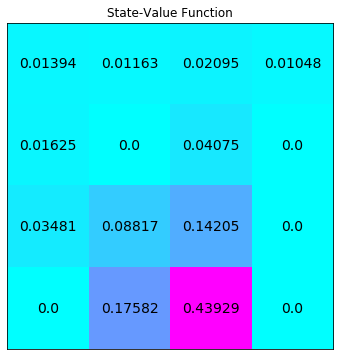

In [58]:
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy)
plot_values_lake(V)

In [184]:
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n)
    count_states = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        count_states_by_update = np.zeros(env.observation_space.n)
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            count_states[current_state] += 1
            count_states_by_update[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(count_states):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - count_states_by_update[state] * V[state]) / count
    return V

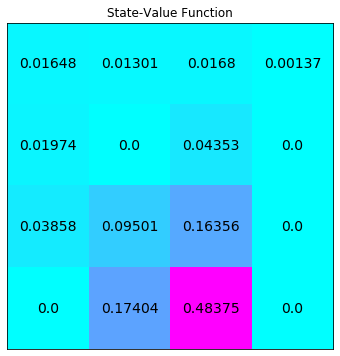

In [194]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

In [140]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

#TODO
explain exploration

In the same way, we estimate the Q function. Ans we build an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

In [188]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, baseline = 1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) * baseline
        #self.q = np.zeros([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward]))
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True:
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)):
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 :
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n):
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 347 - cum reward 0.0
episode: 348 - cum reward 0.0
episode: 349 - cum reward 0.0
episode: 350 - cum reward 0.0
episode: 351 - cum reward 0.0
episode: 352 - cum reward 0.0
episode: 353 - cum reward 0.0
episode: 354 - cum reward 0.0
episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 0.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 0.0
episode: 378 - cum reward 0.0
episode: 379 - cum reward 0.0
episode: 3

episode: 625 - cum reward 0.0
episode: 626 - cum reward 0.0
episode: 627 - cum reward 0.0
episode: 628 - cum reward 0.0
episode: 629 - cum reward 0.0
episode: 630 - cum reward 0.0
episode: 631 - cum reward 0.0
episode: 632 - cum reward 0.0
episode: 633 - cum reward 0.0
episode: 634 - cum reward 0.0
episode: 635 - cum reward 0.0
episode: 636 - cum reward 0.0
episode: 637 - cum reward 0.0
episode: 638 - cum reward 0.0
episode: 639 - cum reward 1.0
episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 642 - cum reward 0.0
episode: 643 - cum reward 0.0
episode: 644 - cum reward 0.0
episode: 645 - cum reward 0.0
episode: 646 - cum reward 0.0
episode: 647 - cum reward 0.0
episode: 648 - cum reward 0.0
episode: 649 - cum reward 0.0
episode: 650 - cum reward 0.0
episode: 651 - cum reward 0.0
episode: 652 - cum reward 0.0
episode: 653 - cum reward 0.0
episode: 654 - cum reward 0.0
episode: 655 - cum reward 0.0
episode: 656 - cum reward 0.0
episode: 657 - cum reward 0.0
episode: 6

episode: 945 - cum reward 0.0
episode: 946 - cum reward 0.0
episode: 947 - cum reward 0.0
episode: 948 - cum reward 0.0
episode: 949 - cum reward 0.0
episode: 950 - cum reward 0.0
episode: 951 - cum reward 0.0
episode: 952 - cum reward 0.0
episode: 953 - cum reward 0.0
episode: 954 - cum reward 0.0
episode: 955 - cum reward 0.0
episode: 956 - cum reward 0.0
episode: 957 - cum reward 0.0
episode: 958 - cum reward 0.0
episode: 959 - cum reward 0.0
episode: 960 - cum reward 0.0
episode: 961 - cum reward 0.0
episode: 962 - cum reward 0.0
episode: 963 - cum reward 0.0
episode: 964 - cum reward 0.0
episode: 965 - cum reward 0.0
episode: 966 - cum reward 0.0
episode: 967 - cum reward 0.0
episode: 968 - cum reward 0.0
episode: 969 - cum reward 0.0
episode: 970 - cum reward 0.0
episode: 971 - cum reward 0.0
episode: 972 - cum reward 0.0
episode: 973 - cum reward 0.0
episode: 974 - cum reward 0.0
episode: 975 - cum reward 0.0
episode: 976 - cum reward 0.0
episode: 977 - cum reward 0.0
episode: 9

episode: 1258 - cum reward 0.0
episode: 1259 - cum reward 0.0
episode: 1260 - cum reward 0.0
episode: 1261 - cum reward 0.0
episode: 1262 - cum reward 0.0
episode: 1263 - cum reward 0.0
episode: 1264 - cum reward 0.0
episode: 1265 - cum reward 0.0
episode: 1266 - cum reward 0.0
episode: 1267 - cum reward 0.0
episode: 1268 - cum reward 0.0
episode: 1269 - cum reward 0.0
episode: 1270 - cum reward 0.0
episode: 1271 - cum reward 0.0
episode: 1272 - cum reward 0.0
episode: 1273 - cum reward 0.0
episode: 1274 - cum reward 0.0
episode: 1275 - cum reward 0.0
episode: 1276 - cum reward 0.0
episode: 1277 - cum reward 0.0
episode: 1278 - cum reward 0.0
episode: 1279 - cum reward 0.0
episode: 1280 - cum reward 0.0
episode: 1281 - cum reward 0.0
episode: 1282 - cum reward 0.0
episode: 1283 - cum reward 0.0
episode: 1284 - cum reward 0.0
episode: 1285 - cum reward 0.0
episode: 1286 - cum reward 0.0
episode: 1287 - cum reward 0.0
episode: 1288 - cum reward 0.0
episode: 1289 - cum reward 0.0
episode:

episode: 1578 - cum reward 0.0
episode: 1579 - cum reward 0.0
episode: 1580 - cum reward 0.0
episode: 1581 - cum reward 0.0
episode: 1582 - cum reward 0.0
episode: 1583 - cum reward 0.0
episode: 1584 - cum reward 0.0
episode: 1585 - cum reward 0.0
episode: 1586 - cum reward 0.0
episode: 1587 - cum reward 0.0
episode: 1588 - cum reward 0.0
episode: 1589 - cum reward 0.0
episode: 1590 - cum reward 0.0
episode: 1591 - cum reward 0.0
episode: 1592 - cum reward 1.0
episode: 1593 - cum reward 0.0
episode: 1594 - cum reward 0.0
episode: 1595 - cum reward 0.0
episode: 1596 - cum reward 0.0
episode: 1597 - cum reward 0.0
episode: 1598 - cum reward 0.0
episode: 1599 - cum reward 0.0
episode: 1600 - cum reward 0.0
episode: 1601 - cum reward 0.0
episode: 1602 - cum reward 0.0
episode: 1603 - cum reward 0.0
episode: 1604 - cum reward 0.0
episode: 1605 - cum reward 0.0
episode: 1606 - cum reward 0.0
episode: 1607 - cum reward 0.0
episode: 1608 - cum reward 0.0
episode: 1609 - cum reward 0.0
episode:

episode: 1899 - cum reward 0.0
episode: 1900 - cum reward 0.0
episode: 1901 - cum reward 0.0
episode: 1902 - cum reward 0.0
episode: 1903 - cum reward 0.0
episode: 1904 - cum reward 0.0
episode: 1905 - cum reward 0.0
episode: 1906 - cum reward 0.0
episode: 1907 - cum reward 0.0
episode: 1908 - cum reward 0.0
episode: 1909 - cum reward 0.0
episode: 1910 - cum reward 1.0
episode: 1911 - cum reward 0.0
episode: 1912 - cum reward 0.0
episode: 1913 - cum reward 0.0
episode: 1914 - cum reward 0.0
episode: 1915 - cum reward 1.0
episode: 1916 - cum reward 0.0
episode: 1917 - cum reward 0.0
episode: 1918 - cum reward 0.0
episode: 1919 - cum reward 0.0
episode: 1920 - cum reward 0.0
episode: 1921 - cum reward 0.0
episode: 1922 - cum reward 0.0
episode: 1923 - cum reward 0.0
episode: 1924 - cum reward 0.0
episode: 1925 - cum reward 0.0
episode: 1926 - cum reward 0.0
episode: 1927 - cum reward 0.0
episode: 1928 - cum reward 0.0
episode: 1929 - cum reward 0.0
episode: 1930 - cum reward 0.0
episode:

episode: 2216 - cum reward 0.0
episode: 2217 - cum reward 0.0
episode: 2218 - cum reward 0.0
episode: 2219 - cum reward 0.0
episode: 2220 - cum reward 0.0
episode: 2221 - cum reward 0.0
episode: 2222 - cum reward 0.0
episode: 2223 - cum reward 0.0
episode: 2224 - cum reward 1.0
episode: 2225 - cum reward 0.0
episode: 2226 - cum reward 0.0
episode: 2227 - cum reward 1.0
episode: 2228 - cum reward 0.0
episode: 2229 - cum reward 0.0
episode: 2230 - cum reward 0.0
episode: 2231 - cum reward 0.0
episode: 2232 - cum reward 0.0
episode: 2233 - cum reward 0.0
episode: 2234 - cum reward 0.0
episode: 2235 - cum reward 1.0
episode: 2236 - cum reward 0.0
episode: 2237 - cum reward 0.0
episode: 2238 - cum reward 0.0
episode: 2239 - cum reward 0.0
episode: 2240 - cum reward 0.0
episode: 2241 - cum reward 0.0
episode: 2242 - cum reward 0.0
episode: 2243 - cum reward 0.0
episode: 2244 - cum reward 0.0
episode: 2245 - cum reward 0.0
episode: 2246 - cum reward 0.0
episode: 2247 - cum reward 0.0
episode:

episode: 2531 - cum reward 0.0
episode: 2532 - cum reward 0.0
episode: 2533 - cum reward 1.0
episode: 2534 - cum reward 0.0
episode: 2535 - cum reward 0.0
episode: 2536 - cum reward 0.0
episode: 2537 - cum reward 0.0
episode: 2538 - cum reward 0.0
episode: 2539 - cum reward 0.0
episode: 2540 - cum reward 0.0
episode: 2541 - cum reward 0.0
episode: 2542 - cum reward 0.0
episode: 2543 - cum reward 0.0
episode: 2544 - cum reward 0.0
episode: 2545 - cum reward 0.0
episode: 2546 - cum reward 0.0
episode: 2547 - cum reward 0.0
episode: 2548 - cum reward 0.0
episode: 2549 - cum reward 0.0
episode: 2550 - cum reward 0.0
episode: 2551 - cum reward 0.0
episode: 2552 - cum reward 0.0
episode: 2553 - cum reward 0.0
episode: 2554 - cum reward 0.0
episode: 2555 - cum reward 0.0
episode: 2556 - cum reward 0.0
episode: 2557 - cum reward 0.0
episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 0.0
episode: 2560 - cum reward 0.0
episode: 2561 - cum reward 0.0
episode: 2562 - cum reward 0.0
episode:

episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 0.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 0.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 0.0
episode: 2869 - cum reward 0.0
episode: 2870 - cum reward 0.0
episode: 2871 - cum reward 0.0
episode: 2872 - cum reward 0.0
episode: 2873 - cum reward 0.0
episode: 2874 - cum reward 0.0
episode: 2875 - cum reward 0.0
episode: 2876 - cum reward 0.0
episode: 2877 - cum reward 0.0
episode: 2878 - cum reward 0.0
episode: 2879 - cum reward 0.0
episode: 2880 - cum reward 0.0
episode: 2881 - cum reward 0.0
episode: 2882 - cum reward 0.0
episode: 2883 - cum reward 0.0
episode: 2884 - cum reward 0.0
episode: 2885 - cum reward 0.0
episode: 2886 - cum reward 0.0
episode: 2887 - cum reward 0.0
episode: 2888 - cum reward 0.0
episode:

episode: 3184 - cum reward 0.0
episode: 3185 - cum reward 0.0
episode: 3186 - cum reward 0.0
episode: 3187 - cum reward 0.0
episode: 3188 - cum reward 1.0
episode: 3189 - cum reward 0.0
episode: 3190 - cum reward 0.0
episode: 3191 - cum reward 0.0
episode: 3192 - cum reward 0.0
episode: 3193 - cum reward 0.0
episode: 3194 - cum reward 0.0
episode: 3195 - cum reward 0.0
episode: 3196 - cum reward 1.0
episode: 3197 - cum reward 0.0
episode: 3198 - cum reward 0.0
episode: 3199 - cum reward 0.0
episode: 3200 - cum reward 1.0
episode: 3201 - cum reward 0.0
episode: 3202 - cum reward 0.0
episode: 3203 - cum reward 0.0
episode: 3204 - cum reward 0.0
episode: 3205 - cum reward 1.0
episode: 3206 - cum reward 0.0
episode: 3207 - cum reward 0.0
episode: 3208 - cum reward 0.0
episode: 3209 - cum reward 0.0
episode: 3210 - cum reward 0.0
episode: 3211 - cum reward 0.0
episode: 3212 - cum reward 1.0
episode: 3213 - cum reward 0.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 0.0
episode:

episode: 3507 - cum reward 0.0
episode: 3508 - cum reward 0.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 1.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 1.0
episode: 3513 - cum reward 0.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode: 3517 - cum reward 0.0
episode: 3518 - cum reward 0.0
episode: 3519 - cum reward 0.0
episode: 3520 - cum reward 0.0
episode: 3521 - cum reward 0.0
episode: 3522 - cum reward 0.0
episode: 3523 - cum reward 0.0
episode: 3524 - cum reward 0.0
episode: 3525 - cum reward 0.0
episode: 3526 - cum reward 0.0
episode: 3527 - cum reward 0.0
episode: 3528 - cum reward 0.0
episode: 3529 - cum reward 0.0
episode: 3530 - cum reward 0.0
episode: 3531 - cum reward 0.0
episode: 3532 - cum reward 0.0
episode: 3533 - cum reward 0.0
episode: 3534 - cum reward 0.0
episode: 3535 - cum reward 0.0
episode: 3536 - cum reward 0.0
episode: 3537 - cum reward 0.0
episode: 3538 - cum reward 0.0
episode:

episode: 3835 - cum reward 0.0
episode: 3836 - cum reward 0.0
episode: 3837 - cum reward 0.0
episode: 3838 - cum reward 0.0
episode: 3839 - cum reward 0.0
episode: 3840 - cum reward 0.0
episode: 3841 - cum reward 0.0
episode: 3842 - cum reward 0.0
episode: 3843 - cum reward 0.0
episode: 3844 - cum reward 0.0
episode: 3845 - cum reward 0.0
episode: 3846 - cum reward 0.0
episode: 3847 - cum reward 0.0
episode: 3848 - cum reward 0.0
episode: 3849 - cum reward 0.0
episode: 3850 - cum reward 0.0
episode: 3851 - cum reward 1.0
episode: 3852 - cum reward 0.0
episode: 3853 - cum reward 0.0
episode: 3854 - cum reward 0.0
episode: 3855 - cum reward 0.0
episode: 3856 - cum reward 0.0
episode: 3857 - cum reward 0.0
episode: 3858 - cum reward 0.0
episode: 3859 - cum reward 0.0
episode: 3860 - cum reward 0.0
episode: 3861 - cum reward 0.0
episode: 3862 - cum reward 0.0
episode: 3863 - cum reward 0.0
episode: 3864 - cum reward 0.0
episode: 3865 - cum reward 0.0
episode: 3866 - cum reward 0.0
episode:

episode: 4169 - cum reward 0.0
episode: 4170 - cum reward 0.0
episode: 4171 - cum reward 0.0
episode: 4172 - cum reward 0.0
episode: 4173 - cum reward 0.0
episode: 4174 - cum reward 0.0
episode: 4175 - cum reward 0.0
episode: 4176 - cum reward 0.0
episode: 4177 - cum reward 0.0
episode: 4178 - cum reward 0.0
episode: 4179 - cum reward 1.0
episode: 4180 - cum reward 0.0
episode: 4181 - cum reward 0.0
episode: 4182 - cum reward 0.0
episode: 4183 - cum reward 0.0
episode: 4184 - cum reward 0.0
episode: 4185 - cum reward 0.0
episode: 4186 - cum reward 0.0
episode: 4187 - cum reward 0.0
episode: 4188 - cum reward 0.0
episode: 4189 - cum reward 0.0
episode: 4190 - cum reward 0.0
episode: 4191 - cum reward 0.0
episode: 4192 - cum reward 0.0
episode: 4193 - cum reward 0.0
episode: 4194 - cum reward 0.0
episode: 4195 - cum reward 0.0
episode: 4196 - cum reward 0.0
episode: 4197 - cum reward 0.0
episode: 4198 - cum reward 0.0
episode: 4199 - cum reward 0.0
episode: 4200 - cum reward 0.0
episode:

episode: 4492 - cum reward 0.0
episode: 4493 - cum reward 0.0
episode: 4494 - cum reward 0.0
episode: 4495 - cum reward 0.0
episode: 4496 - cum reward 0.0
episode: 4497 - cum reward 0.0
episode: 4498 - cum reward 0.0
episode: 4499 - cum reward 0.0
episode: 4500 - cum reward 0.0
episode: 4501 - cum reward 0.0
episode: 4502 - cum reward 0.0
episode: 4503 - cum reward 0.0
episode: 4504 - cum reward 0.0
episode: 4505 - cum reward 0.0
episode: 4506 - cum reward 0.0
episode: 4507 - cum reward 0.0
episode: 4508 - cum reward 0.0
episode: 4509 - cum reward 0.0
episode: 4510 - cum reward 0.0
episode: 4511 - cum reward 0.0
episode: 4512 - cum reward 1.0
episode: 4513 - cum reward 0.0
episode: 4514 - cum reward 0.0
episode: 4515 - cum reward 0.0
episode: 4516 - cum reward 0.0
episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 0.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 0.0
episode: 4523 - cum reward 0.0
episode:

episode: 4811 - cum reward 0.0
episode: 4812 - cum reward 0.0
episode: 4813 - cum reward 0.0
episode: 4814 - cum reward 0.0
episode: 4815 - cum reward 0.0
episode: 4816 - cum reward 1.0
episode: 4817 - cum reward 0.0
episode: 4818 - cum reward 0.0
episode: 4819 - cum reward 0.0
episode: 4820 - cum reward 0.0
episode: 4821 - cum reward 0.0
episode: 4822 - cum reward 0.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 0.0
episode: 4825 - cum reward 0.0
episode: 4826 - cum reward 0.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 0.0
episode: 4830 - cum reward 0.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 0.0
episode: 4834 - cum reward 1.0
episode: 4835 - cum reward 0.0
episode: 4836 - cum reward 1.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 0.0
episode: 4841 - cum reward 0.0
episode: 4842 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

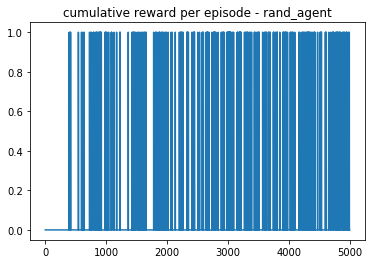

In [189]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [190]:
mc_agent.policy

array([[0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

In [191]:
V = policy_evaluation(env, mc_agent.policy)

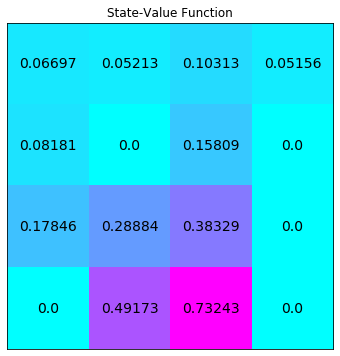

In [192]:
plot_values_lake(V)

In [193]:
V.sum()

2.5884587722749903

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
We also know (bellman equation) $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$. That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [236]:
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    count_states = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        
        
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha# count_states[current_state]
    return V

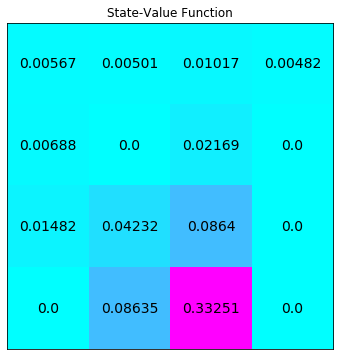

In [237]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [243]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 297 - cum reward 0.0
episode: 298 - cum reward 0.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 1.0
episode: 308 - cum reward 0.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 1.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 1.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 0.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 0.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 0.0
episode: 323 - cum reward 0.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 0.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 3

episode: 643 - cum reward 0.0
episode: 644 - cum reward 0.0
episode: 645 - cum reward 0.0
episode: 646 - cum reward 0.0
episode: 647 - cum reward 0.0
episode: 648 - cum reward 0.0
episode: 649 - cum reward 0.0
episode: 650 - cum reward 0.0
episode: 651 - cum reward 0.0
episode: 652 - cum reward 0.0
episode: 653 - cum reward 0.0
episode: 654 - cum reward 0.0
episode: 655 - cum reward 0.0
episode: 656 - cum reward 0.0
episode: 657 - cum reward 0.0
episode: 658 - cum reward 0.0
episode: 659 - cum reward 0.0
episode: 660 - cum reward 0.0
episode: 661 - cum reward 0.0
episode: 662 - cum reward 0.0
episode: 663 - cum reward 0.0
episode: 664 - cum reward 0.0
episode: 665 - cum reward 0.0
episode: 666 - cum reward 0.0
episode: 667 - cum reward 0.0
episode: 668 - cum reward 0.0
episode: 669 - cum reward 0.0
episode: 670 - cum reward 0.0
episode: 671 - cum reward 0.0
episode: 672 - cum reward 0.0
episode: 673 - cum reward 0.0
episode: 674 - cum reward 0.0
episode: 675 - cum reward 0.0
episode: 6

episode: 989 - cum reward 0.0
episode: 990 - cum reward 0.0
episode: 991 - cum reward 0.0
episode: 992 - cum reward 0.0
episode: 993 - cum reward 0.0
episode: 994 - cum reward 0.0
episode: 995 - cum reward 0.0
episode: 996 - cum reward 0.0
episode: 997 - cum reward 0.0
episode: 998 - cum reward 0.0
episode: 999 - cum reward 0.0
episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.0
episode: 1012 - cum reward 0.0
episode: 1013 - cum reward 0.0
episode: 1014 - cum reward 0.0
episode: 1015 - cum reward 0.0
episode: 1016 - cum reward 0.0
episode: 1017 - cum reward 0.0
episode: 1018 - cum reward 0.0
episode: 1019 - cum reward 0.0
episode: 1020 - cum reward 0.0
episode: 1021 - cum

episode: 1281 - cum reward 0.0
episode: 1282 - cum reward 0.0
episode: 1283 - cum reward 0.0
episode: 1284 - cum reward 0.0
episode: 1285 - cum reward 0.0
episode: 1286 - cum reward 0.0
episode: 1287 - cum reward 0.0
episode: 1288 - cum reward 0.0
episode: 1289 - cum reward 0.0
episode: 1290 - cum reward 0.0
episode: 1291 - cum reward 0.0
episode: 1292 - cum reward 0.0
episode: 1293 - cum reward 0.0
episode: 1294 - cum reward 1.0
episode: 1295 - cum reward 0.0
episode: 1296 - cum reward 0.0
episode: 1297 - cum reward 0.0
episode: 1298 - cum reward 0.0
episode: 1299 - cum reward 0.0
episode: 1300 - cum reward 0.0
episode: 1301 - cum reward 0.0
episode: 1302 - cum reward 0.0
episode: 1303 - cum reward 0.0
episode: 1304 - cum reward 0.0
episode: 1305 - cum reward 0.0
episode: 1306 - cum reward 0.0
episode: 1307 - cum reward 0.0
episode: 1308 - cum reward 0.0
episode: 1309 - cum reward 0.0
episode: 1310 - cum reward 0.0
episode: 1311 - cum reward 0.0
episode: 1312 - cum reward 0.0
episode:

episode: 1580 - cum reward 0.0
episode: 1581 - cum reward 1.0
episode: 1582 - cum reward 0.0
episode: 1583 - cum reward 0.0
episode: 1584 - cum reward 1.0
episode: 1585 - cum reward 0.0
episode: 1586 - cum reward 0.0
episode: 1587 - cum reward 0.0
episode: 1588 - cum reward 0.0
episode: 1589 - cum reward 0.0
episode: 1590 - cum reward 0.0
episode: 1591 - cum reward 0.0
episode: 1592 - cum reward 0.0
episode: 1593 - cum reward 0.0
episode: 1594 - cum reward 0.0
episode: 1595 - cum reward 0.0
episode: 1596 - cum reward 0.0
episode: 1597 - cum reward 0.0
episode: 1598 - cum reward 0.0
episode: 1599 - cum reward 0.0
episode: 1600 - cum reward 0.0
episode: 1601 - cum reward 0.0
episode: 1602 - cum reward 0.0
episode: 1603 - cum reward 0.0
episode: 1604 - cum reward 0.0
episode: 1605 - cum reward 0.0
episode: 1606 - cum reward 0.0
episode: 1607 - cum reward 0.0
episode: 1608 - cum reward 0.0
episode: 1609 - cum reward 0.0
episode: 1610 - cum reward 0.0
episode: 1611 - cum reward 0.0
episode:

episode: 1934 - cum reward 0.0
episode: 1935 - cum reward 0.0
episode: 1936 - cum reward 0.0
episode: 1937 - cum reward 0.0
episode: 1938 - cum reward 0.0
episode: 1939 - cum reward 0.0
episode: 1940 - cum reward 0.0
episode: 1941 - cum reward 0.0
episode: 1942 - cum reward 0.0
episode: 1943 - cum reward 0.0
episode: 1944 - cum reward 0.0
episode: 1945 - cum reward 0.0
episode: 1946 - cum reward 0.0
episode: 1947 - cum reward 0.0
episode: 1948 - cum reward 0.0
episode: 1949 - cum reward 0.0
episode: 1950 - cum reward 0.0
episode: 1951 - cum reward 0.0
episode: 1952 - cum reward 0.0
episode: 1953 - cum reward 0.0
episode: 1954 - cum reward 0.0
episode: 1955 - cum reward 0.0
episode: 1956 - cum reward 0.0
episode: 1957 - cum reward 0.0
episode: 1958 - cum reward 1.0
episode: 1959 - cum reward 0.0
episode: 1960 - cum reward 0.0
episode: 1961 - cum reward 0.0
episode: 1962 - cum reward 0.0
episode: 1963 - cum reward 0.0
episode: 1964 - cum reward 0.0
episode: 1965 - cum reward 0.0
episode:

episode: 2201 - cum reward 0.0
episode: 2202 - cum reward 0.0
episode: 2203 - cum reward 0.0
episode: 2204 - cum reward 0.0
episode: 2205 - cum reward 0.0
episode: 2206 - cum reward 0.0
episode: 2207 - cum reward 0.0
episode: 2208 - cum reward 0.0
episode: 2209 - cum reward 0.0
episode: 2210 - cum reward 0.0
episode: 2211 - cum reward 0.0
episode: 2212 - cum reward 0.0
episode: 2213 - cum reward 0.0
episode: 2214 - cum reward 0.0
episode: 2215 - cum reward 0.0
episode: 2216 - cum reward 0.0
episode: 2217 - cum reward 0.0
episode: 2218 - cum reward 0.0
episode: 2219 - cum reward 0.0
episode: 2220 - cum reward 0.0
episode: 2221 - cum reward 0.0
episode: 2222 - cum reward 0.0
episode: 2223 - cum reward 0.0
episode: 2224 - cum reward 0.0
episode: 2225 - cum reward 0.0
episode: 2226 - cum reward 0.0
episode: 2227 - cum reward 0.0
episode: 2228 - cum reward 0.0
episode: 2229 - cum reward 0.0
episode: 2230 - cum reward 0.0
episode: 2231 - cum reward 0.0
episode: 2232 - cum reward 0.0
episode:

episode: 2540 - cum reward 1.0
episode: 2541 - cum reward 1.0
episode: 2542 - cum reward 0.0
episode: 2543 - cum reward 0.0
episode: 2544 - cum reward 0.0
episode: 2545 - cum reward 0.0
episode: 2546 - cum reward 0.0
episode: 2547 - cum reward 0.0
episode: 2548 - cum reward 0.0
episode: 2549 - cum reward 0.0
episode: 2550 - cum reward 0.0
episode: 2551 - cum reward 0.0
episode: 2552 - cum reward 0.0
episode: 2553 - cum reward 0.0
episode: 2554 - cum reward 0.0
episode: 2555 - cum reward 0.0
episode: 2556 - cum reward 0.0
episode: 2557 - cum reward 0.0
episode: 2558 - cum reward 0.0
episode: 2559 - cum reward 0.0
episode: 2560 - cum reward 0.0
episode: 2561 - cum reward 0.0
episode: 2562 - cum reward 1.0
episode: 2563 - cum reward 0.0
episode: 2564 - cum reward 0.0
episode: 2565 - cum reward 0.0
episode: 2566 - cum reward 0.0
episode: 2567 - cum reward 1.0
episode: 2568 - cum reward 0.0
episode: 2569 - cum reward 0.0
episode: 2570 - cum reward 0.0
episode: 2571 - cum reward 0.0
episode:

episode: 2838 - cum reward 0.0
episode: 2839 - cum reward 0.0
episode: 2840 - cum reward 0.0
episode: 2841 - cum reward 0.0
episode: 2842 - cum reward 0.0
episode: 2843 - cum reward 0.0
episode: 2844 - cum reward 0.0
episode: 2845 - cum reward 0.0
episode: 2846 - cum reward 0.0
episode: 2847 - cum reward 0.0
episode: 2848 - cum reward 0.0
episode: 2849 - cum reward 0.0
episode: 2850 - cum reward 0.0
episode: 2851 - cum reward 1.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 0.0
episode: 2855 - cum reward 0.0
episode: 2856 - cum reward 0.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 0.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 0.0
episode: 2861 - cum reward 0.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 1.0
episode: 2864 - cum reward 0.0
episode: 2865 - cum reward 0.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 1.0
episode: 2869 - cum reward 0.0
episode:

episode: 3121 - cum reward 0.0
episode: 3122 - cum reward 0.0
episode: 3123 - cum reward 0.0
episode: 3124 - cum reward 0.0
episode: 3125 - cum reward 0.0
episode: 3126 - cum reward 0.0
episode: 3127 - cum reward 0.0
episode: 3128 - cum reward 0.0
episode: 3129 - cum reward 0.0
episode: 3130 - cum reward 0.0
episode: 3131 - cum reward 0.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 0.0
episode: 3134 - cum reward 0.0
episode: 3135 - cum reward 0.0
episode: 3136 - cum reward 0.0
episode: 3137 - cum reward 0.0
episode: 3138 - cum reward 0.0
episode: 3139 - cum reward 0.0
episode: 3140 - cum reward 0.0
episode: 3141 - cum reward 0.0
episode: 3142 - cum reward 1.0
episode: 3143 - cum reward 0.0
episode: 3144 - cum reward 0.0
episode: 3145 - cum reward 0.0
episode: 3146 - cum reward 0.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 0.0
episode: 3149 - cum reward 0.0
episode: 3150 - cum reward 0.0
episode: 3151 - cum reward 0.0
episode: 3152 - cum reward 0.0
episode:

episode: 3437 - cum reward 0.0
episode: 3438 - cum reward 0.0
episode: 3439 - cum reward 0.0
episode: 3440 - cum reward 0.0
episode: 3441 - cum reward 0.0
episode: 3442 - cum reward 0.0
episode: 3443 - cum reward 1.0
episode: 3444 - cum reward 1.0
episode: 3445 - cum reward 0.0
episode: 3446 - cum reward 0.0
episode: 3447 - cum reward 0.0
episode: 3448 - cum reward 1.0
episode: 3449 - cum reward 0.0
episode: 3450 - cum reward 0.0
episode: 3451 - cum reward 0.0
episode: 3452 - cum reward 0.0
episode: 3453 - cum reward 0.0
episode: 3454 - cum reward 0.0
episode: 3455 - cum reward 0.0
episode: 3456 - cum reward 0.0
episode: 3457 - cum reward 0.0
episode: 3458 - cum reward 0.0
episode: 3459 - cum reward 0.0
episode: 3460 - cum reward 0.0
episode: 3461 - cum reward 0.0
episode: 3462 - cum reward 0.0
episode: 3463 - cum reward 0.0
episode: 3464 - cum reward 0.0
episode: 3465 - cum reward 0.0
episode: 3466 - cum reward 0.0
episode: 3467 - cum reward 0.0
episode: 3468 - cum reward 0.0
episode:

episode: 3711 - cum reward 0.0
episode: 3712 - cum reward 0.0
episode: 3713 - cum reward 0.0
episode: 3714 - cum reward 0.0
episode: 3715 - cum reward 0.0
episode: 3716 - cum reward 0.0
episode: 3717 - cum reward 0.0
episode: 3718 - cum reward 0.0
episode: 3719 - cum reward 0.0
episode: 3720 - cum reward 0.0
episode: 3721 - cum reward 0.0
episode: 3722 - cum reward 0.0
episode: 3723 - cum reward 0.0
episode: 3724 - cum reward 0.0
episode: 3725 - cum reward 0.0
episode: 3726 - cum reward 0.0
episode: 3727 - cum reward 0.0
episode: 3728 - cum reward 1.0
episode: 3729 - cum reward 0.0
episode: 3730 - cum reward 0.0
episode: 3731 - cum reward 0.0
episode: 3732 - cum reward 0.0
episode: 3733 - cum reward 0.0
episode: 3734 - cum reward 0.0
episode: 3735 - cum reward 0.0
episode: 3736 - cum reward 0.0
episode: 3737 - cum reward 0.0
episode: 3738 - cum reward 0.0
episode: 3739 - cum reward 0.0
episode: 3740 - cum reward 0.0
episode: 3741 - cum reward 0.0
episode: 3742 - cum reward 0.0
episode:

episode: 3977 - cum reward 0.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 0.0
episode: 3981 - cum reward 1.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 0.0
episode: 3986 - cum reward 1.0
episode: 3987 - cum reward 1.0
episode: 3988 - cum reward 0.0
episode: 3989 - cum reward 1.0
episode: 3990 - cum reward 1.0
episode: 3991 - cum reward 1.0
episode: 3992 - cum reward 0.0
episode: 3993 - cum reward 1.0
episode: 3994 - cum reward 0.0
episode: 3995 - cum reward 0.0
episode: 3996 - cum reward 0.0
episode: 3997 - cum reward 1.0
episode: 3998 - cum reward 1.0
episode: 3999 - cum reward 1.0
episode: 4000 - cum reward 1.0
episode: 4001 - cum reward 1.0
episode: 4002 - cum reward 0.0
episode: 4003 - cum reward 0.0
episode: 4004 - cum reward 0.0
episode: 4005 - cum reward 0.0
episode: 4006 - cum reward 0.0
episode: 4007 - cum reward 1.0
episode: 4008 - cum reward 0.0
episode:

episode: 4279 - cum reward 1.0
episode: 4280 - cum reward 0.0
episode: 4281 - cum reward 0.0
episode: 4282 - cum reward 0.0
episode: 4283 - cum reward 0.0
episode: 4284 - cum reward 1.0
episode: 4285 - cum reward 0.0
episode: 4286 - cum reward 0.0
episode: 4287 - cum reward 0.0
episode: 4288 - cum reward 1.0
episode: 4289 - cum reward 0.0
episode: 4290 - cum reward 0.0
episode: 4291 - cum reward 0.0
episode: 4292 - cum reward 1.0
episode: 4293 - cum reward 0.0
episode: 4294 - cum reward 0.0
episode: 4295 - cum reward 0.0
episode: 4296 - cum reward 0.0
episode: 4297 - cum reward 0.0
episode: 4298 - cum reward 1.0
episode: 4299 - cum reward 1.0
episode: 4300 - cum reward 0.0
episode: 4301 - cum reward 0.0
episode: 4302 - cum reward 0.0
episode: 4303 - cum reward 0.0
episode: 4304 - cum reward 1.0
episode: 4305 - cum reward 1.0
episode: 4306 - cum reward 0.0
episode: 4307 - cum reward 0.0
episode: 4308 - cum reward 0.0
episode: 4309 - cum reward 0.0
episode: 4310 - cum reward 1.0
episode:

episode: 4571 - cum reward 0.0
episode: 4572 - cum reward 1.0
episode: 4573 - cum reward 0.0
episode: 4574 - cum reward 1.0
episode: 4575 - cum reward 0.0
episode: 4576 - cum reward 0.0
episode: 4577 - cum reward 1.0
episode: 4578 - cum reward 1.0
episode: 4579 - cum reward 0.0
episode: 4580 - cum reward 1.0
episode: 4581 - cum reward 1.0
episode: 4582 - cum reward 1.0
episode: 4583 - cum reward 0.0
episode: 4584 - cum reward 0.0
episode: 4585 - cum reward 0.0
episode: 4586 - cum reward 1.0
episode: 4587 - cum reward 0.0
episode: 4588 - cum reward 1.0
episode: 4589 - cum reward 0.0
episode: 4590 - cum reward 0.0
episode: 4591 - cum reward 0.0
episode: 4592 - cum reward 0.0
episode: 4593 - cum reward 0.0
episode: 4594 - cum reward 1.0
episode: 4595 - cum reward 0.0
episode: 4596 - cum reward 0.0
episode: 4597 - cum reward 1.0
episode: 4598 - cum reward 0.0
episode: 4599 - cum reward 1.0
episode: 4600 - cum reward 0.0
episode: 4601 - cum reward 1.0
episode: 4602 - cum reward 0.0
episode:

episode: 4839 - cum reward 0.0
episode: 4840 - cum reward 1.0
episode: 4841 - cum reward 0.0
episode: 4842 - cum reward 0.0
episode: 4843 - cum reward 1.0
episode: 4844 - cum reward 0.0
episode: 4845 - cum reward 0.0
episode: 4846 - cum reward 0.0
episode: 4847 - cum reward 0.0
episode: 4848 - cum reward 1.0
episode: 4849 - cum reward 0.0
episode: 4850 - cum reward 0.0
episode: 4851 - cum reward 0.0
episode: 4852 - cum reward 1.0
episode: 4853 - cum reward 1.0
episode: 4854 - cum reward 1.0
episode: 4855 - cum reward 1.0
episode: 4856 - cum reward 0.0
episode: 4857 - cum reward 0.0
episode: 4858 - cum reward 0.0
episode: 4859 - cum reward 0.0
episode: 4860 - cum reward 1.0
episode: 4861 - cum reward 1.0
episode: 4862 - cum reward 1.0
episode: 4863 - cum reward 1.0
episode: 4864 - cum reward 0.0
episode: 4865 - cum reward 0.0
episode: 4866 - cum reward 1.0
episode: 4867 - cum reward 0.0
episode: 4868 - cum reward 0.0
episode: 4869 - cum reward 0.0
episode: 4870 - cum reward 1.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

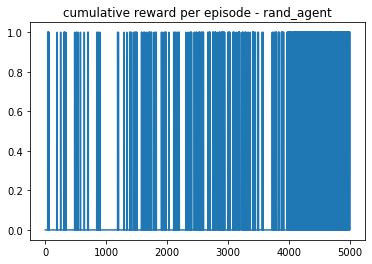

In [249]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [250]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

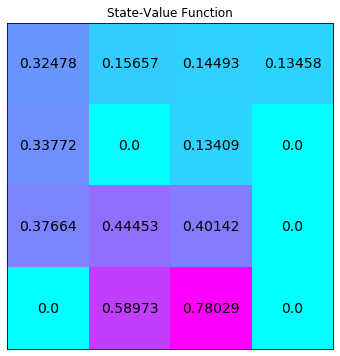

In [251]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [252]:
V.sum()

3.82529659386428

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [259]:
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 1.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 1.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 1.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 1.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 1.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 285 - cum reward 0.0
episode: 286 - cum reward 0.0
episode: 287 - cum reward 0.0
episode: 288 - cum reward 0.0
episode: 289 - cum reward 0.0
episode: 290 - cum reward 0.0
episode: 291 - cum reward 0.0
episode: 292 - cum reward 0.0
episode: 293 - cum reward 0.0
episode: 294 - cum reward 0.0
episode: 295 - cum reward 0.0
episode: 296 - cum reward 0.0
episode: 297 - cum reward 0.0
episode: 298 - cum reward 1.0
episode: 299 - cum reward 0.0
episode: 300 - cum reward 0.0
episode: 301 - cum reward 1.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 1.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 1.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 1.0
episode: 317 - cum reward 0.0
episode: 3

episode: 592 - cum reward 1.0
episode: 593 - cum reward 0.0
episode: 594 - cum reward 0.0
episode: 595 - cum reward 0.0
episode: 596 - cum reward 1.0
episode: 597 - cum reward 0.0
episode: 598 - cum reward 0.0
episode: 599 - cum reward 0.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 0.0
episode: 602 - cum reward 0.0
episode: 603 - cum reward 0.0
episode: 604 - cum reward 0.0
episode: 605 - cum reward 1.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 0.0
episode: 608 - cum reward 1.0
episode: 609 - cum reward 0.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 0.0
episode: 615 - cum reward 0.0
episode: 616 - cum reward 0.0
episode: 617 - cum reward 0.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 0.0
episode: 620 - cum reward 0.0
episode: 621 - cum reward 0.0
episode: 622 - cum reward 0.0
episode: 623 - cum reward 0.0
episode: 624 - cum reward 0.0
episode: 6

episode: 875 - cum reward 0.0
episode: 876 - cum reward 0.0
episode: 877 - cum reward 1.0
episode: 878 - cum reward 0.0
episode: 879 - cum reward 0.0
episode: 880 - cum reward 1.0
episode: 881 - cum reward 1.0
episode: 882 - cum reward 0.0
episode: 883 - cum reward 1.0
episode: 884 - cum reward 1.0
episode: 885 - cum reward 1.0
episode: 886 - cum reward 0.0
episode: 887 - cum reward 0.0
episode: 888 - cum reward 0.0
episode: 889 - cum reward 0.0
episode: 890 - cum reward 1.0
episode: 891 - cum reward 0.0
episode: 892 - cum reward 1.0
episode: 893 - cum reward 0.0
episode: 894 - cum reward 1.0
episode: 895 - cum reward 0.0
episode: 896 - cum reward 0.0
episode: 897 - cum reward 0.0
episode: 898 - cum reward 1.0
episode: 899 - cum reward 0.0
episode: 900 - cum reward 0.0
episode: 901 - cum reward 0.0
episode: 902 - cum reward 0.0
episode: 903 - cum reward 0.0
episode: 904 - cum reward 0.0
episode: 905 - cum reward 0.0
episode: 906 - cum reward 1.0
episode: 907 - cum reward 0.0
episode: 9

episode: 1146 - cum reward 1.0
episode: 1147 - cum reward 0.0
episode: 1148 - cum reward 0.0
episode: 1149 - cum reward 0.0
episode: 1150 - cum reward 0.0
episode: 1151 - cum reward 0.0
episode: 1152 - cum reward 1.0
episode: 1153 - cum reward 1.0
episode: 1154 - cum reward 1.0
episode: 1155 - cum reward 1.0
episode: 1156 - cum reward 0.0
episode: 1157 - cum reward 1.0
episode: 1158 - cum reward 1.0
episode: 1159 - cum reward 1.0
episode: 1160 - cum reward 1.0
episode: 1161 - cum reward 1.0
episode: 1162 - cum reward 1.0
episode: 1163 - cum reward 0.0
episode: 1164 - cum reward 1.0
episode: 1165 - cum reward 0.0
episode: 1166 - cum reward 0.0
episode: 1167 - cum reward 1.0
episode: 1168 - cum reward 0.0
episode: 1169 - cum reward 1.0
episode: 1170 - cum reward 0.0
episode: 1171 - cum reward 1.0
episode: 1172 - cum reward 0.0
episode: 1173 - cum reward 1.0
episode: 1174 - cum reward 1.0
episode: 1175 - cum reward 0.0
episode: 1176 - cum reward 0.0
episode: 1177 - cum reward 0.0
episode:

episode: 1433 - cum reward 0.0
episode: 1434 - cum reward 0.0
episode: 1435 - cum reward 1.0
episode: 1436 - cum reward 0.0
episode: 1437 - cum reward 1.0
episode: 1438 - cum reward 1.0
episode: 1439 - cum reward 1.0
episode: 1440 - cum reward 1.0
episode: 1441 - cum reward 1.0
episode: 1442 - cum reward 0.0
episode: 1443 - cum reward 1.0
episode: 1444 - cum reward 0.0
episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 0.0
episode: 1447 - cum reward 0.0
episode: 1448 - cum reward 0.0
episode: 1449 - cum reward 0.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 1.0
episode: 1452 - cum reward 0.0
episode: 1453 - cum reward 0.0
episode: 1454 - cum reward 0.0
episode: 1455 - cum reward 1.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 1.0
episode: 1458 - cum reward 1.0
episode: 1459 - cum reward 0.0
episode: 1460 - cum reward 0.0
episode: 1461 - cum reward 1.0
episode: 1462 - cum reward 1.0
episode: 1463 - cum reward 1.0
episode: 1464 - cum reward 1.0
episode:

episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 0.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 0.0
episode: 1723 - cum reward 0.0
episode: 1724 - cum reward 0.0
episode: 1725 - cum reward 0.0
episode: 1726 - cum reward 0.0
episode: 1727 - cum reward 0.0
episode: 1728 - cum reward 0.0
episode: 1729 - cum reward 0.0
episode: 1730 - cum reward 0.0
episode: 1731 - cum reward 1.0
episode: 1732 - cum reward 1.0
episode: 1733 - cum reward 0.0
episode: 1734 - cum reward 0.0
episode: 1735 - cum reward 0.0
episode: 1736 - cum reward 1.0
episode: 1737 - cum reward 1.0
episode: 1738 - cum reward 0.0
episode: 1739 - cum reward 1.0
episode: 1740 - cum reward 0.0
episode: 1741 - cum reward 1.0
episode: 1742 - cum reward 1.0
episode: 1743 - cum reward 0.0
episode: 1744 - cum reward 1.0
episode: 1745 - cum reward 1.0
episode: 1746 - cum reward 1.0
episode: 1747 - cum reward 1.0
episode: 1748 - cum reward 0.0
episode: 1749 - cum reward 1.0
episode: 1750 - cum reward 1.0
episode:

episode: 2011 - cum reward 0.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 0.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 0.0
episode: 2016 - cum reward 0.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 1.0
episode: 2019 - cum reward 0.0
episode: 2020 - cum reward 0.0
episode: 2021 - cum reward 1.0
episode: 2022 - cum reward 0.0
episode: 2023 - cum reward 1.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 1.0
episode: 2026 - cum reward 1.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 0.0
episode: 2029 - cum reward 0.0
episode: 2030 - cum reward 0.0
episode: 2031 - cum reward 0.0
episode: 2032 - cum reward 1.0
episode: 2033 - cum reward 1.0
episode: 2034 - cum reward 0.0
episode: 2035 - cum reward 0.0
episode: 2036 - cum reward 1.0
episode: 2037 - cum reward 1.0
episode: 2038 - cum reward 0.0
episode: 2039 - cum reward 0.0
episode: 2040 - cum reward 0.0
episode: 2041 - cum reward 0.0
episode: 2042 - cum reward 0.0
episode:

episode: 2299 - cum reward 0.0
episode: 2300 - cum reward 1.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 1.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 1.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 1.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 1.0
episode: 2309 - cum reward 1.0
episode: 2310 - cum reward 1.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 1.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 0.0
episode: 2315 - cum reward 1.0
episode: 2316 - cum reward 1.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 0.0
episode: 2321 - cum reward 1.0
episode: 2322 - cum reward 1.0
episode: 2323 - cum reward 1.0
episode: 2324 - cum reward 0.0
episode: 2325 - cum reward 0.0
episode: 2326 - cum reward 1.0
episode: 2327 - cum reward 0.0
episode: 2328 - cum reward 0.0
episode: 2329 - cum reward 1.0
episode: 2330 - cum reward 1.0
episode:

episode: 2593 - cum reward 0.0
episode: 2594 - cum reward 1.0
episode: 2595 - cum reward 1.0
episode: 2596 - cum reward 0.0
episode: 2597 - cum reward 0.0
episode: 2598 - cum reward 0.0
episode: 2599 - cum reward 0.0
episode: 2600 - cum reward 1.0
episode: 2601 - cum reward 0.0
episode: 2602 - cum reward 0.0
episode: 2603 - cum reward 1.0
episode: 2604 - cum reward 0.0
episode: 2605 - cum reward 1.0
episode: 2606 - cum reward 0.0
episode: 2607 - cum reward 0.0
episode: 2608 - cum reward 0.0
episode: 2609 - cum reward 0.0
episode: 2610 - cum reward 0.0
episode: 2611 - cum reward 0.0
episode: 2612 - cum reward 0.0
episode: 2613 - cum reward 1.0
episode: 2614 - cum reward 0.0
episode: 2615 - cum reward 1.0
episode: 2616 - cum reward 1.0
episode: 2617 - cum reward 0.0
episode: 2618 - cum reward 0.0
episode: 2619 - cum reward 0.0
episode: 2620 - cum reward 1.0
episode: 2621 - cum reward 0.0
episode: 2622 - cum reward 1.0
episode: 2623 - cum reward 0.0
episode: 2624 - cum reward 0.0
episode:

episode: 2864 - cum reward 1.0
episode: 2865 - cum reward 1.0
episode: 2866 - cum reward 0.0
episode: 2867 - cum reward 0.0
episode: 2868 - cum reward 1.0
episode: 2869 - cum reward 0.0
episode: 2870 - cum reward 1.0
episode: 2871 - cum reward 0.0
episode: 2872 - cum reward 0.0
episode: 2873 - cum reward 0.0
episode: 2874 - cum reward 0.0
episode: 2875 - cum reward 1.0
episode: 2876 - cum reward 0.0
episode: 2877 - cum reward 1.0
episode: 2878 - cum reward 1.0
episode: 2879 - cum reward 1.0
episode: 2880 - cum reward 0.0
episode: 2881 - cum reward 0.0
episode: 2882 - cum reward 1.0
episode: 2883 - cum reward 0.0
episode: 2884 - cum reward 0.0
episode: 2885 - cum reward 0.0
episode: 2886 - cum reward 0.0
episode: 2887 - cum reward 0.0
episode: 2888 - cum reward 1.0
episode: 2889 - cum reward 0.0
episode: 2890 - cum reward 0.0
episode: 2891 - cum reward 0.0
episode: 2892 - cum reward 1.0
episode: 2893 - cum reward 1.0
episode: 2894 - cum reward 1.0
episode: 2895 - cum reward 1.0
episode:

episode: 3130 - cum reward 1.0
episode: 3131 - cum reward 1.0
episode: 3132 - cum reward 0.0
episode: 3133 - cum reward 1.0
episode: 3134 - cum reward 1.0
episode: 3135 - cum reward 1.0
episode: 3136 - cum reward 0.0
episode: 3137 - cum reward 0.0
episode: 3138 - cum reward 0.0
episode: 3139 - cum reward 0.0
episode: 3140 - cum reward 0.0
episode: 3141 - cum reward 1.0
episode: 3142 - cum reward 0.0
episode: 3143 - cum reward 1.0
episode: 3144 - cum reward 0.0
episode: 3145 - cum reward 0.0
episode: 3146 - cum reward 0.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 0.0
episode: 3149 - cum reward 1.0
episode: 3150 - cum reward 0.0
episode: 3151 - cum reward 1.0
episode: 3152 - cum reward 0.0
episode: 3153 - cum reward 1.0
episode: 3154 - cum reward 0.0
episode: 3155 - cum reward 0.0
episode: 3156 - cum reward 0.0
episode: 3157 - cum reward 0.0
episode: 3158 - cum reward 0.0
episode: 3159 - cum reward 0.0
episode: 3160 - cum reward 0.0
episode: 3161 - cum reward 0.0
episode:

episode: 3403 - cum reward 0.0
episode: 3404 - cum reward 1.0
episode: 3405 - cum reward 1.0
episode: 3406 - cum reward 1.0
episode: 3407 - cum reward 1.0
episode: 3408 - cum reward 0.0
episode: 3409 - cum reward 0.0
episode: 3410 - cum reward 1.0
episode: 3411 - cum reward 0.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 0.0
episode: 3414 - cum reward 0.0
episode: 3415 - cum reward 0.0
episode: 3416 - cum reward 1.0
episode: 3417 - cum reward 0.0
episode: 3418 - cum reward 1.0
episode: 3419 - cum reward 1.0
episode: 3420 - cum reward 0.0
episode: 3421 - cum reward 1.0
episode: 3422 - cum reward 1.0
episode: 3423 - cum reward 1.0
episode: 3424 - cum reward 0.0
episode: 3425 - cum reward 1.0
episode: 3426 - cum reward 1.0
episode: 3427 - cum reward 1.0
episode: 3428 - cum reward 1.0
episode: 3429 - cum reward 0.0
episode: 3430 - cum reward 1.0
episode: 3431 - cum reward 1.0
episode: 3432 - cum reward 0.0
episode: 3433 - cum reward 1.0
episode: 3434 - cum reward 0.0
episode:

episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 1.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 1.0
episode: 3695 - cum reward 0.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 1.0
episode: 3698 - cum reward 1.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 0.0
episode: 3702 - cum reward 0.0
episode: 3703 - cum reward 1.0
episode: 3704 - cum reward 0.0
episode: 3705 - cum reward 1.0
episode: 3706 - cum reward 1.0
episode: 3707 - cum reward 0.0
episode: 3708 - cum reward 1.0
episode: 3709 - cum reward 0.0
episode: 3710 - cum reward 1.0
episode: 3711 - cum reward 0.0
episode: 3712 - cum reward 1.0
episode: 3713 - cum reward 0.0
episode: 3714 - cum reward 1.0
episode: 3715 - cum reward 1.0
episode: 3716 - cum reward 1.0
episode: 3717 - cum reward 0.0
episode: 3718 - cum reward 1.0
episode: 3719 - cum reward 0.0
episode: 3720 - cum reward 0.0
episode: 3721 - cum reward 1.0
episode: 3722 - cum reward 0.0
episode:

episode: 3960 - cum reward 0.0
episode: 3961 - cum reward 0.0
episode: 3962 - cum reward 0.0
episode: 3963 - cum reward 1.0
episode: 3964 - cum reward 0.0
episode: 3965 - cum reward 0.0
episode: 3966 - cum reward 0.0
episode: 3967 - cum reward 1.0
episode: 3968 - cum reward 1.0
episode: 3969 - cum reward 1.0
episode: 3970 - cum reward 0.0
episode: 3971 - cum reward 1.0
episode: 3972 - cum reward 1.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 1.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 1.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 0.0
episode: 3980 - cum reward 1.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 0.0
episode: 3984 - cum reward 0.0
episode: 3985 - cum reward 0.0
episode: 3986 - cum reward 1.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 1.0
episode: 3989 - cum reward 1.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 0.0
episode:

episode: 4238 - cum reward 0.0
episode: 4239 - cum reward 0.0
episode: 4240 - cum reward 0.0
episode: 4241 - cum reward 0.0
episode: 4242 - cum reward 1.0
episode: 4243 - cum reward 1.0
episode: 4244 - cum reward 0.0
episode: 4245 - cum reward 1.0
episode: 4246 - cum reward 1.0
episode: 4247 - cum reward 0.0
episode: 4248 - cum reward 0.0
episode: 4249 - cum reward 1.0
episode: 4250 - cum reward 1.0
episode: 4251 - cum reward 1.0
episode: 4252 - cum reward 1.0
episode: 4253 - cum reward 0.0
episode: 4254 - cum reward 1.0
episode: 4255 - cum reward 1.0
episode: 4256 - cum reward 0.0
episode: 4257 - cum reward 0.0
episode: 4258 - cum reward 0.0
episode: 4259 - cum reward 0.0
episode: 4260 - cum reward 1.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 0.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 1.0
episode: 4266 - cum reward 0.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 1.0
episode:

episode: 4514 - cum reward 0.0
episode: 4515 - cum reward 1.0
episode: 4516 - cum reward 1.0
episode: 4517 - cum reward 0.0
episode: 4518 - cum reward 1.0
episode: 4519 - cum reward 0.0
episode: 4520 - cum reward 0.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 1.0
episode: 4523 - cum reward 1.0
episode: 4524 - cum reward 0.0
episode: 4525 - cum reward 0.0
episode: 4526 - cum reward 0.0
episode: 4527 - cum reward 1.0
episode: 4528 - cum reward 0.0
episode: 4529 - cum reward 1.0
episode: 4530 - cum reward 0.0
episode: 4531 - cum reward 0.0
episode: 4532 - cum reward 1.0
episode: 4533 - cum reward 0.0
episode: 4534 - cum reward 0.0
episode: 4535 - cum reward 1.0
episode: 4536 - cum reward 1.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 0.0
episode: 4539 - cum reward 0.0
episode: 4540 - cum reward 1.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 0.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 1.0
episode: 4545 - cum reward 1.0
episode:

episode: 4790 - cum reward 0.0
episode: 4791 - cum reward 1.0
episode: 4792 - cum reward 0.0
episode: 4793 - cum reward 0.0
episode: 4794 - cum reward 0.0
episode: 4795 - cum reward 0.0
episode: 4796 - cum reward 0.0
episode: 4797 - cum reward 1.0
episode: 4798 - cum reward 0.0
episode: 4799 - cum reward 1.0
episode: 4800 - cum reward 0.0
episode: 4801 - cum reward 1.0
episode: 4802 - cum reward 1.0
episode: 4803 - cum reward 0.0
episode: 4804 - cum reward 0.0
episode: 4805 - cum reward 0.0
episode: 4806 - cum reward 0.0
episode: 4807 - cum reward 0.0
episode: 4808 - cum reward 0.0
episode: 4809 - cum reward 0.0
episode: 4810 - cum reward 1.0
episode: 4811 - cum reward 1.0
episode: 4812 - cum reward 1.0
episode: 4813 - cum reward 0.0
episode: 4814 - cum reward 0.0
episode: 4815 - cum reward 1.0
episode: 4816 - cum reward 0.0
episode: 4817 - cum reward 0.0
episode: 4818 - cum reward 0.0
episode: 4819 - cum reward 1.0
episode: 4820 - cum reward 0.0
episode: 4821 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

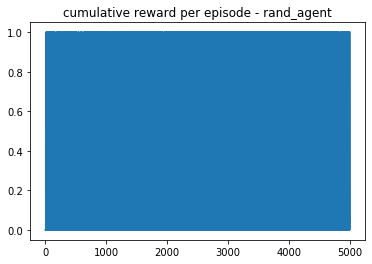

In [264]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

In [265]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

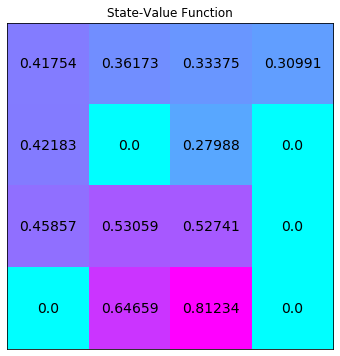

In [266]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [267]:
V.sum()

5.100116629064201

In [268]:
# Question: Why we don't have the optimal policy?

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}